# [월간 데이콘 14] 신용카드 사용자 연체 예측 AI 경진대회

[1등 커널 score : 0.6581](https://dacon.io/competitions/official/235713/codeshare/2768?page=1&dtype=recent)

In [1]:
 # 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings('ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Preprocessing

In [3]:
# 결측치 처리
train.fillna('NaN', inplace = True)
test.fillna('NaN', inplace = True)

In [4]:
# 이상치 처리
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop = True)

##  Feture Engineering

In [5]:
#  의미 없는 변수 제거
train.drop(['index', 'FLAG_MOBIL'], axis = 1, inplace = True)
test.drop(['index', 'FLAG_MOBIL'], axis = 1, inplace = True)

In [6]:
# DAYS_EMPLOYED -> 양수인 데이터는 무직자로 판단하여 0 처리
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x : 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x : 0 if x > 0 else x)

In [7]:
# 양수로 변환
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']

for feat in feats:
    train[feat] = np.abs(train[feat])
    test[feat] = np.abs(test[feat])

In [8]:
# 파생변수 생성

for df in [train, test]:
    # before_EMPLOYED :  고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_beforeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    # DAYS_BIRTH의 파생변수 : 나이, 태어난 월, 태어난 주
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    # DAYS_EMPLOYED_m 파생변수 : 근속연수, 고용된 달, 고용된 주
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    # ability : 소득 / (살아온 일수 + 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    # income mean : 소득 / 가족 구성원의 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    # ID 변수 생성
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)
    # 한 사람이 여러 개의 카드를 만들 수 있으므로 begin_month는 제거

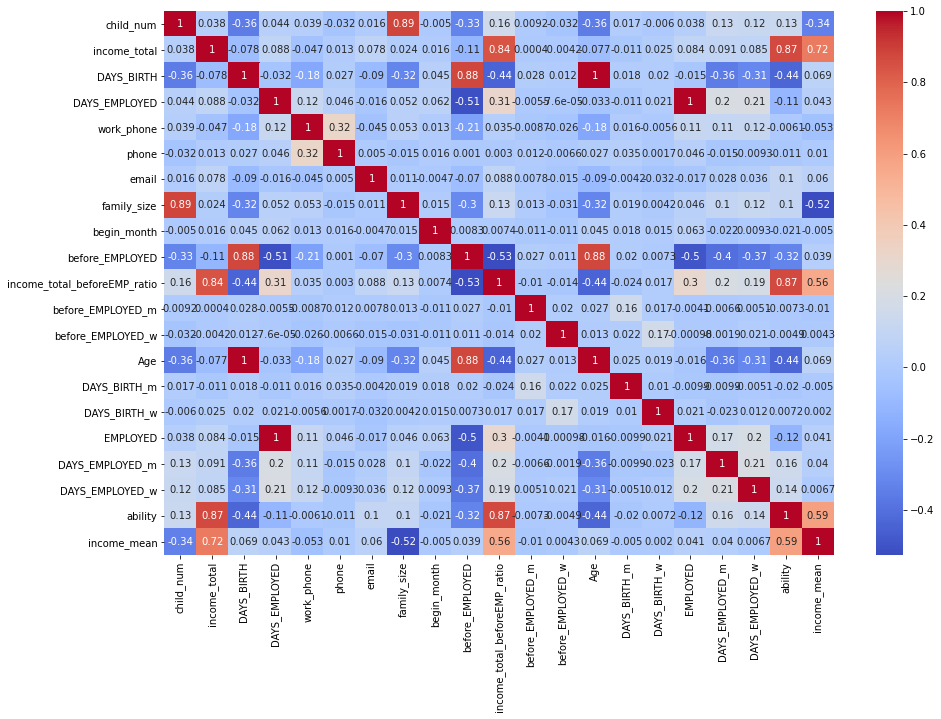

In [9]:
# 상관계수 행렬 히트맨
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), cmap = 'coolwarm', annot = True)
plt.show()

- child_num
- DAYS_BIRTH
- DAYS_EMPLOYED

다중공선성이 높은 변수들 제거

In [10]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
train.drop(cols, axis = 1, inplace = True)
test.drop(cols, axis = 1, inplace = True)

## Scaling and Encoding

In [11]:
# numeric, category 컬럼 분류
numerical_feats = train.dtypes[train.dtypes != 'object'].index.tolist()
numerical_feats.remove('credit')
print('Number of Numerical features: ', len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == 'object'].index.tolist()
print('Number of Categorical features: ', len(categorical_feats))

Number of Numerical features:  18
Number of Categorical features:  9


In [12]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_beforeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [13]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

### Log scaling

In [14]:
# skew가 높은 income_total을 로그 변환 해줌
for df in [train, test]:
    df['income_total'] = np.log1p(1+df['income_total'])

### OrdinalEncoder
- 카테고리 변수는 Ordinal Encoder로 변환
- ID는 변환 후, 정수 처리

In [15]:
# encoding
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.fit_transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

### 클러스터링

In [16]:
# clustering
kmeans_train = train.drop('credit', axis = 1)
kmeans = KMeans(n_clusters = 36, random_state = 42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [17]:
# log 변환한 income_total을 제외한 나머지 변수들 정규화
numerical_feats.remove('income_total')

scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.fit_transform(test[numerical_feats])

## 모델링

In [18]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis = 1)
y = train[target]
X_test = test

In [19]:
skfold = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state = 42)
folds = []

for train_idx, valid_idx, in skfold.split(X,y):
    folds.append((train_idx, valid_idx))
    
cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------FOLD{fold}---------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data = X_train, label = y_train, cat_features=cat_cols)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features=cat_cols)
    
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set = valid_data, use_best_model = True, early_stopping_rounds = 100, verbose = 100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------FOLD0---------------

Learning rate set to 0.115127
0:	learn: 1.0346960	test: 1.0333820	best: 1.0333820 (0)	total: 164ms	remaining: 2m 43s
100:	learn: 0.7053286	test: 0.6430792	best: 0.6430792 (100)	total: 6.96s	remaining: 1m 1s
200:	learn: 0.6869753	test: 0.6410587	best: 0.6410587 (200)	total: 14.5s	remaining: 57.5s
300:	learn: 0.6692872	test: 0.6411961	best: 0.6401680 (255)	total: 21.6s	remaining: 50.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6401680369
bestIteration = 255

Shrink model to first 256 iterations.
CV Log Loss Score: 0.640168

----------FOLD1---------------

Learning rate set to 0.115127
0:	learn: 1.0346110	test: 1.0339653	best: 1.0339653 (0)	total: 19.3ms	remaining: 19.2s
100:	learn: 0.7034008	test: 0.6758889	best: 0.6758889 (100)	total: 6.42s	remaining: 57.1s
200:	learn: 0.6847406	test: 0.6752899	best: 0.6747008 (116)	total: 13.2s	remaining: 52.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6747007623
bes

100:	learn: 0.7039908	test: 0.6732031	best: 0.6732031 (100)	total: 6.54s	remaining: 58.2s
200:	learn: 0.6866462	test: 0.6711190	best: 0.6707680 (179)	total: 13.6s	remaining: 54.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6707679941
bestIteration = 179

Shrink model to first 180 iterations.
CV Log Loss Score: 0.670768
	Log Loss: 0.665453


In [20]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

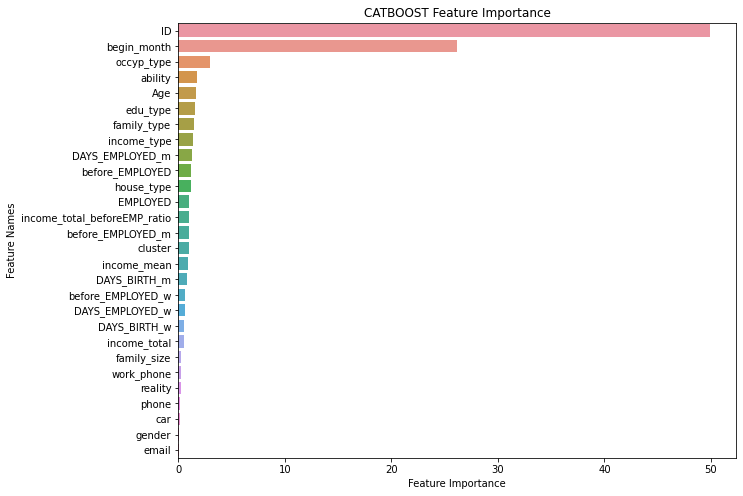

In [21]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')